<div align="Center"><h1>Capital One Data Challenge:</h1></div>
<div align="Center"><h2>HMDA Data Analysis</h2></div>

To start the analysis, we need to set up the environment by importing necessary packages, then read the data in for preliminary assessments:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
institutions=pd.read_csv('C:/Users/nquan/Google Drive/Dropbox/Jobs/Capital One/Data Challenge/data-challenge-data-master/2012_to_2014_institutions_data.csv')
loans=pd.read_csv('C:/Users/nquan/Google Drive/Dropbox/Jobs/Capital One/Data Challenge/data-challenge-data-master/2012_to_2014_loans_data.csv')

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3,4,5,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<div align="Left"><h3>Loan Bucketing</h3></div>

In order to fit Loan Amount in different buckets, we need to look at how the loan amounts are distributed. First, some summary statistics and a histogram of all loans:

Loan Amount Summary Statistics:
count    1.321158e+06
mean     2.902331e+02
std      9.657792e+02
min      1.000000e+00
25%      1.530000e+02
50%      2.350000e+02
75%      3.470000e+02
max      9.962500e+04
Name: Loan_Amount_000, dtype: float64


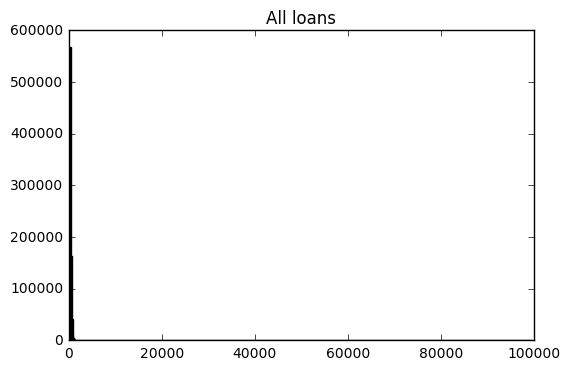

In [3]:
print('Loan Amount Summary Statistics:')
print(loans['Loan_Amount_000'].describe())

plt.title('All loans')
plt.hist(loans['Loan_Amount_000'], bins=500)
plt.show()

We can see the distribution is highly skewed to the left. Loan amounts range from 1K to 99625K, but the mean and median are only 290K and 235K. There is a high concentration of loans in the low end of the range. After a few plotting iterations, I found the most loans are under 5000K. Past this mark, the frequencies of loan amounts are significantly lower. Histogram visualizations suggest that [5000K, 42000K) and [42000, max) are the 2 ranges where loan amounts are rather uniformly distributed, as shown by the following histograms:

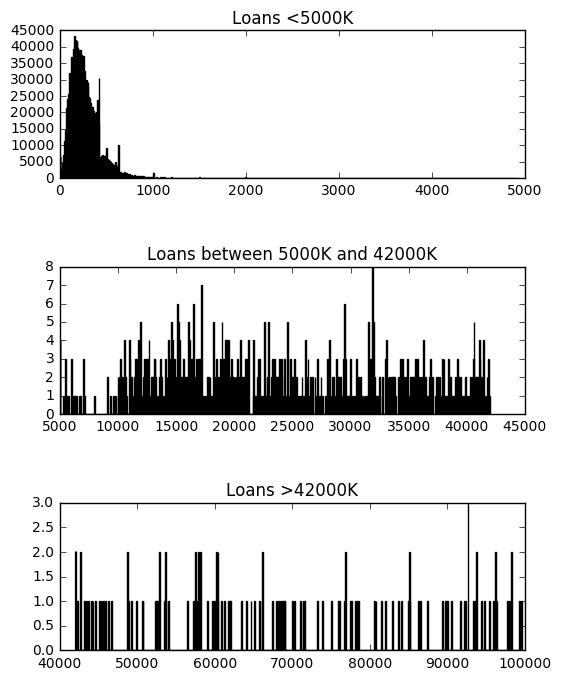

In [4]:
plt.figure(figsize=(6,8))

#First bucket of loans
bucket1=loans[(loans['Loan_Amount_000']<5000)]['Loan_Amount_000']
plt.subplot(311)
plt.title('Loans <5000K')
plt.hist(bucket1, bins=500)

#Second bucket of loans
bucket2=loans[(loans['Loan_Amount_000']>=5000)&(loans['Loan_Amount_000']<42000)]['Loan_Amount_000']
plt.subplot(312)
plt.title('Loans between 5000K and 42000K')
plt.hist(bucket2, bins=500)

#Third bucket of loans
bucket3=loans[(loans['Loan_Amount_000']>=42000)]['Loan_Amount_000']
plt.subplot(313)
plt.title('Loans >42000K')
plt.hist(bucket3, bins=500)

plt.subplots_adjust(hspace=.6)
plt.show()

<h3>Data merging and API Definition</h3>
<br>
With the above system of bucketing loans, data import and export functions can be defined to construct the API. In the hmda_init function, the loans data and institutions data are merged by an inner join on Agency Code and Respondent ID.

In [5]:
def hmda_init(loans_path, institutions_path):
    loans=pd.read_csv(loans_path)
    institutions=pd.read_csv(institutions_path)
    
    hmda=pd.merge(loans, institutions, on=['Agency_Code', 'Respondent_ID', 'As_of_Year'], how='inner')
        
    #Generate loan buckets and concatenate this column with the hmda data
    loan_bucket=[]
    for i in range(0,len(hmda)):
        if hmda['Loan_Amount_000'][i]<5000:
            loan_bucket.append(1)
        elif hmda['Loan_Amount_000'][i]<42000:
            loan_bucket.append(2)
        else:
            loan_bucket.append(3)
    loanbucketdf=pd.DataFrame(loan_bucket, columns=['Loan_Bucket'], index=hmda.index)
    hmda=pd.concat([hmda, loanbucketdf], axis=1)
    return hmda

def hmda_to_json(data, states, conventional_conforming, path):
    if all(x in list(hmda['State'].unique()) for x in list(states)):
           #check if the input for states is valid (exists in the data)
        if conventional_conforming=='Y' or conventional_conforming=='N':
            output=data[data['State'].isin(states)][data['Conventional_Conforming_Flag']==conventional_conforming]
            output.to_json(path)
        else:
            print('Please enter a valid Conventional_Conforming_Flag.')
    else:
        print ('Please enter a valid state(s) (2-letter abbreviation).')


With the above functions, we can initialize the hmda data:

In [6]:
hmda=hmda_init(loans_path='C:/Users/nquan/Google Drive/Dropbox/Jobs/Capital One/Data Challenge/data-challenge-data-master/2012_to_2014_loans_data.csv',
               institutions_path='C:/Users/nquan/Google Drive/Dropbox/Jobs/Capital One/Data Challenge/data-challenge-data-master/2012_to_2014_institutions_data.csv')

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (3,4,5,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<h3>Quality Check:</h3>
One of the data quality checkpoints is data completeness. This is indicated by whether there are blanks/nulls in the data. So we first perform this check on the hmda data:

In [7]:
nullindex=hmda.isnull()
colnames=list(nullindex)
nullcounter=[]
total=len(hmda)
for i in range(0,nullindex.shape[1]):
    nullcounter.append(total-list(Counter(nullindex[colnames[i]]).values())[0])

nullcounts=pd.DataFrame({'Column': colnames, 'Null_Count': nullcounter})
print(nullcounts)

                            Column  Null_Count
0                      Agency_Code           0
1             Applicant_Income_000           0
2                       As_of_Year           0
3              Census_Tract_Number           0
4                      County_Code           0
5       FFIEC_Median_Family_Income           0
6                  Loan_Amount_000           0
7                           MSA_MD           0
8   Number_of_Owner_Occupied_Units           0
9                    Respondent_ID           0
10                 Sequence_Number           0
11                      State_Code           0
12      Tract_to_MSA_MD_Income_Pct         900
13              MSA_MD_Description       95217
14        Loan_Purpose_Description           0
15         Agency_Code_Description           0
16         Lien_Status_Description           0
17           Loan_Type_Description           0
18                           State           0
19                     County_Name         837
20           

<b>1. Loan Amount:</b>
<br>
Loan amount is one of the more important measures within this data set. The null check above shows that loan amount data is complete (no nulls). Next step is to review summary statistics:

In [8]:
#All loans
print('Summary Statistics-All Loans:')
print(hmda['Loan_Amount_000'].describe())
print('\n')

#Conventional loans
print('Summary Statistics-Conventional Loans:')
print(hmda[hmda['Conventional_Status']=='Conventional']['Loan_Amount_000'].describe())
print('\n')

#Non-Conventional loans
print('Summary Statistics-Non-Conventional Loans:')
print(hmda[hmda['Conventional_Status']=='Non-Conventional']['Loan_Amount_000'].describe())
print('\n')

#Conforming loans
print('Summary Statistics-Conforming Loans:')
print(hmda[hmda['Conforming_Status']=='Conforming']['Loan_Amount_000'].describe())
print('\n')

#Non-Conforming loans
print('Summary Statistics-Non-Conforming/Jumbo Loans:')
print(hmda[hmda['Conforming_Status']=='Jumbo']['Loan_Amount_000'].describe())
print('\n')

Summary Statistics-All Loans:
count    1.222854e+06
mean     2.870880e+02
std      1.002149e+03
min      1.000000e+00
25%      1.510000e+02
50%      2.300000e+02
75%      3.400000e+02
max      9.962500e+04
Name: Loan_Amount_000, dtype: float64


Summary Statistics-Conventional Loans:
count    852605.000000
mean        298.833283
std        1196.473689
min           1.000000
25%         145.000000
50%         230.000000
75%         348.000000
max       99625.000000
Name: Loan_Amount_000, dtype: float64


Summary Statistics-Non-Conventional Loans:
count    370249.000000
mean        260.041148
std         139.281308
min           2.000000
25%         162.000000
50%         230.000000
75%         327.000000
max        7000.000000
Name: Loan_Amount_000, dtype: float64


Summary Statistics-Conforming Loans:
count    1.166664e+06
mean     2.413614e+02
std      1.248535e+02
min      1.000000e+00
25%      1.480000e+02
50%      2.220000e+02
75%      3.200000e+02
max      6.250000e+02
Name: Loan_

We can also check whether the data fits the description. In particular, whether loans indicated as "Conforming" actually are under the Conforming Limit. Since the below query return nil, we know the data first the indication flag for Conforming Status.

In [9]:
hmda[(hmda['Loan_Amount_000']>hmda['Conforming_Limit_000']) & (hmda['Conforming_Status']=='Conforming')]

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Respondent_Name_TS,Respondent_City_TS,Respondent_State_TS,Respondent_ZIP_Code,Parent_Name_TS,Parent_City_TS,Parent_State_TS,Parent_ZIP_Code,Assets_000_Panel,Loan_Bucket


<b>2. Respondent Name:</b>
<br>
While this field passes the completeness test (no nulls), in the institutions data, we can see Respondent Names are sometimes different between the years for the same Agency Code + Respondent combination. Apparently the name of the institution can change over the years, but there could be some case of typing errors as well. More importantly, many of the names appear to be cut off (Ex: "NEW CARLISLE FEDERAL SAVINGS B", "WOODRUFF FEDERAL SAVINGS & LOA", etc.). This could have resulted from the analog-digital conversion (i.e. paper input to digital data).

In [10]:
print(institutions[['Agency_Code','Respondent_ID','Respondent_Name_TS','As_of_Year']].drop_duplicates().sort_values(by=['Agency_Code','Respondent_ID','Respondent_Name_TS','As_of_Year'], ascending=[1,1,1,1]).head())

       Agency_Code Respondent_ID              Respondent_Name_TS  As_of_Year
14592            1    0000000046  FIRST NATIONAL BANK OF MCCONNE        2014
0                1    0000000047         FIRST FINANCIAL BANK NA        2012
7401             1    0000000047         FIRST FINANCIAL BANK NA        2013
14593            1    0000000047         FIRST FINANCIAL BANK NA        2014
1                1    0000000056      FIRST FINANCIAL BANK, N.A.        2012


<b>3. Other important columns:</b>
<br>
Per the above check for nulls, the following columns were flagged:

In [11]:
print(nullcounts[nullcounts['Null_Count']>0])

                        Column  Null_Count
12  Tract_to_MSA_MD_Income_Pct         900
13          MSA_MD_Description       95217
19                 County_Name         837
20        Conforming_Limit_000         837
28              Parent_Name_TS      627211
29              Parent_City_TS      627211
30             Parent_State_TS      627069
31             Parent_ZIP_Code      626646


It's important to maintain data completeness and accuracy so that the business intelligence generated is accurate for strategic decision making. Among these columns, Conforming_Limit_000 is important for determining the Conforming Status of the loan, and County Name is important for determining market size as will be discussed below. Within County Name, a number of typos/abbrevation were found, which led to difficulties in visualizing the data. Thus, the following function is created to fix the errors.

In [12]:
def fix_county_typo(data):
    data.loc[data['County_Name']=='DISTRICT OF COL','County_Name']='DISTRICT OF COLUMBIA'
    data.loc[data['County_Name']=='COLONIAL HEIGHT','County_Name']='COLONIAL HEIGHTS'
    return data

hmda=fix_county_typo(hmda)

<h3>Should Change Financial enter the market in these states?</h3>

I hypothesize that the decision to enter the market depends on the following factors:
- Market size
- Competition

<b>1. Market size:</b>
<br>
The bigger the market, the more opportunities. An estimator of this is the number of historical loans. The following interactive visualization shows the number of loans for counties within the states present in this data set.
<i>(Visualization generates in a new page, also attached)</i>

In [13]:
import bokeh
from bokeh.plotting import figure, show, output_file
#bokeh.sampledata.download()
from bokeh.sampledata.us_counties import data as backupcounties
counties=backupcounties.copy()
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
palette.reverse()

#Set map focus by removing non-contiguous states if they exist
if 'HI' in list(states.keys()):
    del states["HI"]
if 'AK' in list(states.keys()):
    del states["AK"]
EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]

hmdastatescounties=(hmda.groupby(['State','County_Name']).size())

#Remove counties in base data that don't exist in this data set
for i in counties.copy():
    if str.upper(counties[i]['state']) not in hmdastatescounties.index.get_level_values(0):
        del(counties[i])
    elif str.upper(counties[i]['name']) not in list(hmdastatescounties[str.upper(counties[i]['state'])].index):
        del(counties[i])
    else:
        counties[i]['loancount']=hmdastatescounties[str.upper(counties[i]['state'])][str.upper(counties[i]['name'])]

county_xs=[counties[code]["lons"] for code in counties if counties[code]["state"] not in EXCLUDED]
county_ys=[counties[code]["lats"] for code in counties if counties[code]["state"] not in EXCLUDED]


color_mapper = LogColorMapper(palette=palette)

county_names = [county['name'] for county in counties.values()]
state_names = [str.upper(county['state']) for county in counties.values()]
county_rates = [county['loancount'] for county in counties.values()]
color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    state_name=state_names,
    rate=county_rates,
))

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"


p = figure(
    title="Market Size: Loan Count by County", tools=TOOLS,
    x_axis_location=None, y_axis_location=None, plot_width=1100, plot_height=700,
    x_range=(-85, -74), y_range=(36, 41))


p.grid.grid_line_color = None

p.patches(state_xs, state_ys, fill_alpha=0.0,
          line_color="#585858", line_width=2, line_alpha=1)

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.6, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("County Name", "@name"),
    ("State Name", "@state_name"),
    ("Loan Count)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_file("Market_Size_Plot.html")
show(p)
#Plot generated in a separated html file

<b>2. Competition:</b>
<br>
The decision to enter a market can depend on the level of competition in that market. With high competition, it's not easy to enter, since there are barriers such as customer preference, first mover's advantage, etc. The following chart shows how many insititutions (based on Agency and Respondent codes).

In [14]:
competitors_by_state=hmda[['State','Agency_Code', 'Respondent_ID', 'Respondent_Name_TS']].drop_duplicates(subset=['State','Agency_Code', 'Respondent_ID'])
competitors_count=competitors_by_state.groupby('State').size()

from bokeh.charts import Bar, output_file, show
p = Bar(competitors_count, title='Competitors Count')
output_file("Competition_by_State.html")
show(p)
#Plot generated in a separated html file

INFO:bokeh.core.state:Session output file 'Competition_by_State.html' already exists, will be overwritten.


We can see that in MD and VA, there significantly more competitors (800-1000) compared to the remaining states (<500). But we also know from the above analysis that counties in MD and VA (and therefore these states as a whole) have more loans. The deciding factor might be the ratio between market size and competition. If competition outweighs potential business opportunities, then it might not be a good idea to enter the market, and vice versa.

We can get the ratios by calculating the number of loans per competitor:

In [15]:
statelcount=hmda.groupby(['State']).size()
ratio=statelcount/competitors_count
print(ratio)

State
DC    108.944934
DE    129.907368
MD    531.888367
VA    585.497482
WV    163.475789
dtype: float64


The above ratios show that on average MD and VA have significantly more loans per competitor than other states. This is a strong sign that the markets in these states are not saturated, and there is still opportunity for an entry.

To understand further who the big players are, we can take a closer look at the leaders in each state. The following code generate pie charts with insights on market share:

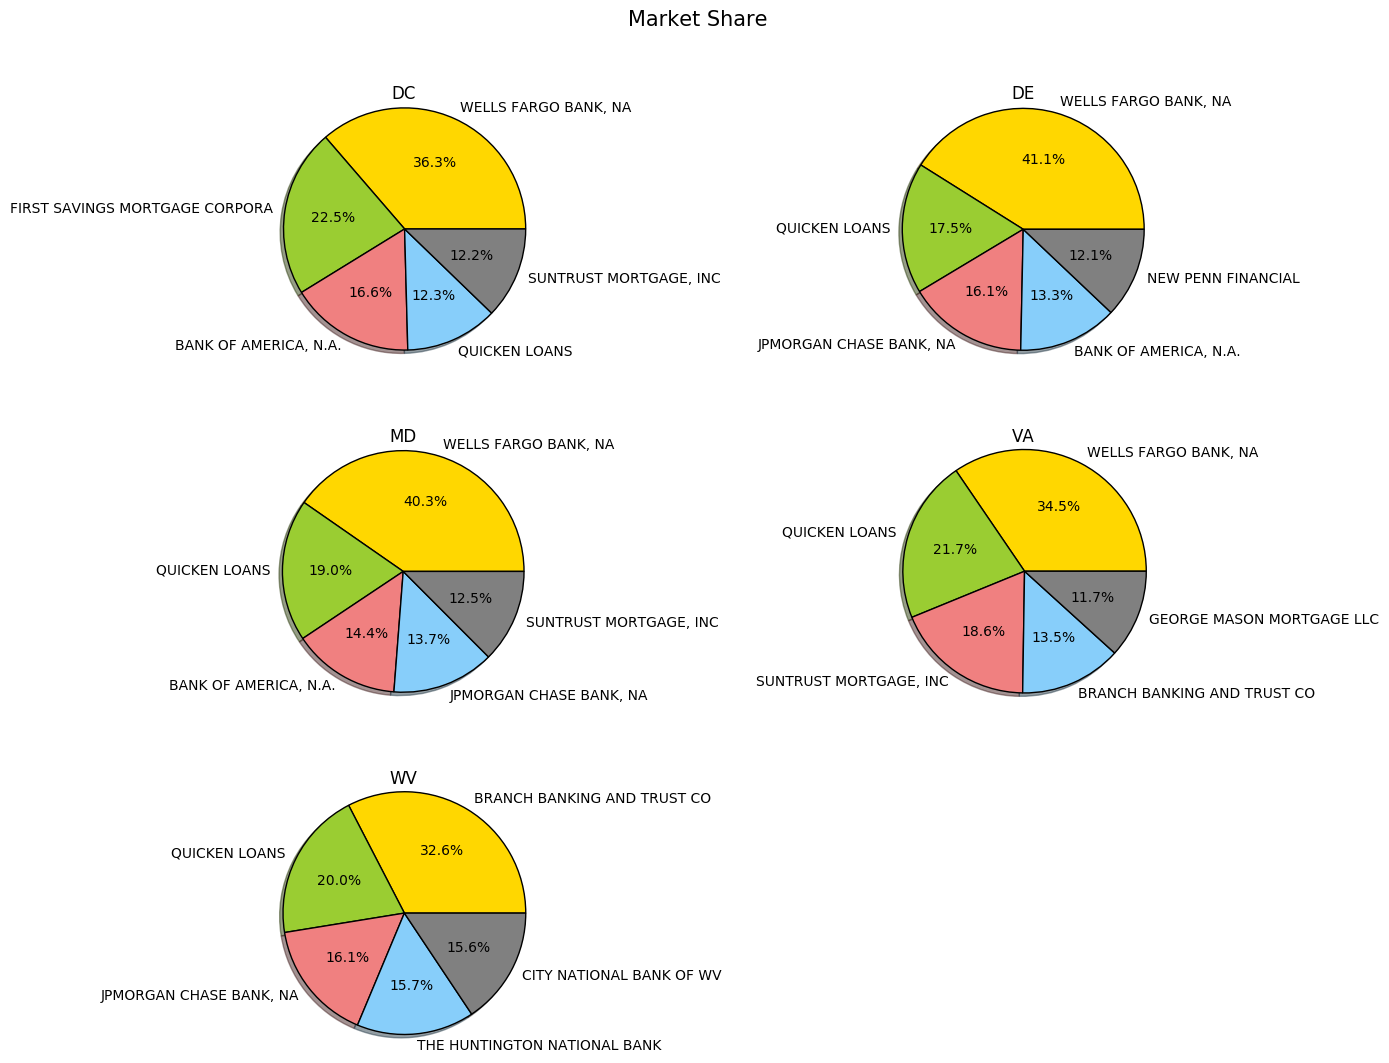

In [17]:
def topnindex(a,N):
    return np.argsort(a)[::-1][:N]

def toplcountfromstate(hmda, state, n):
    lcountbyresp=hmda.groupby(['State','Respondent_ID']).size()
    topindex=list(topnindex(lcountbyresp[state],n))
    topresp=[]
    toplcount=[]
    for i in range(0,n):
        topresp.append(list(hmda[hmda['Respondent_ID']==lcountbyresp[state].index.get_level_values(0)[topindex[i]]]['Respondent_Name_TS'])[0])
        toplcount.append(lcountbyresp[state][topindex[i]])
    return pd.DataFrame({'Loan Count': toplcount, 'Respondent': topresp})

def plotpie(state,pos):
    plt.subplot(pos)
    # Data to plot
    labels = list(toplcountfromstate(hmda,state,5)['Respondent'])
    sizes = list(toplcountfromstate(hmda,state,5)['Loan Count'])
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'grey']
    # Plot
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=0)
    plt.title(state)
    plt.axis('equal')

plt.figure(figsize=(12,12))
plt.suptitle('Market Share', fontsize=15)

plotpie('DC',321)
plotpie('DE',322)
plotpie('MD',323)
plotpie('VA',324)
plotpie('WV',325)
plt.subplots_adjust(hspace=.4)
plt.subplots_adjust(wspace=1)
plt.show()

We can clearly see a number of common themes between these markets: Wells Fargo and Quicken Loans have strong presence in most, if not all states. Suntrust and Bank of America also have good market share in 3 out of 5 states. Further studies of these market leaders might shed light on what helps them succeed in these markets, and how a new comer can distinguish itself to appeal to customers.